# Topic Modelによる類似文献の提示手法について
@date 2019.08.14  
@author Kenta Matsui  


## 参考文献 
[1]"Latent Dirichlet Allocation",  http://papers.nips.cc/paper/2070-latent-dirichlet-allocation.pdf   
[2]"LDAvis: A method for visualizing and interpreting topics", https://www.aclweb.org/anthology/W14-3110　　  
[3]"gensimのLDA評価指標coherenceの使い方", https://qiita.com/tatsuya-miyamoto/items/7d49959c74f3c1e0cf63


## ライブラリのインポート

In [1]:
import time
from datetime import datetime
import pickle
import logging
from collections import Counter
from pprint import pprint

import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
import pandas as pd

# Natural Language Processing Libraries
import gensim
from gensim import similarities     
from gensim.test.utils import get_tmpfile, common_texts
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Vizualization
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Local
from topic_model import TopicModel
from error_definition import Result

import warnings
warnings.filterwarnings('ignore')

## Topic modelの初期化

トピック数はハイパーパラメタなので、学習では決まらない。色々なトピック数を試してみて、学習が一番「うまくいった」ときの値を最適な値として使うことはできる。

In [2]:
# ラッパークラスの初期化
topic_model = TopicModel(logger_level=logging.WARN )

# stopwordsや前処理要データを落としてくる
topic_model.load_nltk_data()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# デバッグ用にarxivsから論文のabstractを使う
df = pd.read_csv("./arxivs_data_large.csv")
df = df.sample(frac=1, random_state=0).reset_index() # 時系列でなくすためシャッフル

In [6]:
# %time topic_model.create_corpus_from_df(df, num_docs = 100)
# %time topic_model.create_corpus_from_df(df, num_docs = 200)
# %time topic_model.create_corpus_from_df(df, num_docs = 300) 
# %time topic_model.create_corpus_from_df(df, num_docs = 1000)
# %time topic_model.create_corpus_from_df(df, num_docs = 2000) 
%time topic_model.create_corpus_from_df(df, num_docs = 50000) # 線形で時間かかるようだ

docs from df
texts from docs
create fictionary
create corpus
CPU times: user 13min 31s, sys: 4.01 s, total: 13min 35s
Wall time: 13min 36s


## Topic modelの学習
色々パラメータがあるが、あまり調整できるようにはしていない。トピックの個数(num_topics)だけは必須である。num_passを多くすると学習時間が長くなるが、結果が収束しやすいと考えられる。

また、gensim以外の実装（MALLET）のモデルも使える。ただし、MALLETの場合は後述のPerplexityの計算が使えない。

In [7]:
# トピック数を決める
topic_model.set_num_topics(10)

# 学習の開始
topic_model.train(num_pass=10)

<Result.SUCCESS: 6>

## 学習結果の確認
どれだけ学習がうまくいっているかの指標として、Perplexityがある。これが小さな値となっていれば、うまく学習できていると言える。  （ランダムに単語を生成するのではなく、文書に現れる単語を限られた単語の中から選ぶ方が良いモデル（汎化性能が高い）だと言えるので、Perplexityが小さいほど良いモデル(汎化性能が高い)だと言える。）  

また、Coherenceも指標として用いることができる。こちらは0~1の値をとり、大きくなるほどトピックの品質が良いと言える。  

gensimのMALLETのwrapperがPerplexityを計算する関数を持っていない買ったので、今回はcoherenceを指標とする。


In [8]:
pprint(topic_model.get_model_info())

{'date': datetime.datetime(2019, 8, 21, 20, 46, 24, 683624),
 'num_docs': 50000,
 'num_topics': 10}


PerplexityとCoherenceを計算する。

In [9]:
num_all_words = len(topic_model.dictionary)
perplexity = topic_model.calc_perplexity()
coherence = topic_model.calc_coherence(method='c_uci') # c_usiのほうが計算が高速。デフォルトはc_vで、精度はよいが計算が遅い。
print("Perplexity = " + str(perplexity))
print("Perplexity / Num_total_words =  " + str(perplexity/num_all_words))
print("Coherence = " + str(coherence))

Perplexity = 302.47607130466287
Perplexity / Num_total_words =  0.004852972521253094
Coherence = 0.15511359608581538


簡単に結果を可視化することができる。左半分の円の集まりは、各円がトピックを表しており、その半径が文献の数を表す。位置関係は、およそのトピックの距離を表しているため、うまく散らばっているほどよいと言える。（ただし、本来多次元空間での話を無理やし2次元空間にうつしたものであることに注意。）  
右半分は、各トピックでの単語の割合を可視化しており、水色が全体の単語数、赤色がそのトピックが占める単語数を表す。

In [10]:
vis = pyLDAvis.gensim.prepare(topic_model.lda, topic_model.corpuses, topic_model.dictionary, sort_topics=False, mds="tsne") # t-sneだときれいにわかれて”見える”
vis

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      17.293459        1       1  153.603607 -170.403275
1       1.841889        1       2 -164.973755  -60.103775
2       5.907692        1       3   40.668839  -66.633858
3      14.767303        1       4  191.324844  187.866455
4      25.169104        1       5   94.769409   71.957954
5       9.618534        1       6    2.124126  214.987717
6      10.300027        1       7  -52.110657   49.350643
7       3.697755        1       8 -171.356415  142.039917
8       7.873694        1       9  -47.920158 -192.463989
9       3.530531        1      10  230.691025   -9.864563, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
22668  Default  31911.000000     algorithm  31911.000000  30.0000  30.0000
1776   Default  32718.000000       problem  32718.000000  29.0000  29.0000
30639  Default  50857.000000         model  50857.000000  28.0000  28.0000
18659  Default  14969.000000         graph  14969.000000  27.0000  27.0000
50536  Default  35806.000000       network  35806.000000  26.0000  26.0000
48618  Default  17147.000000         image  17147.000000  25.0000  25.0000
29273  Default  30688.000000        method  30688.000000  24.0000  24.0000
27913  Default   8619.000000          code   8619.000000  23.0000  23.0000
3905   Default  29600.000000        system  29600.000000  22.0000  22.0000
48021  Default  35090.000000       propose  35090.000000  21.0000  21.0000
33385  Default  16517.000000         learn  16517.000000  20.0000  20.0000
54401  Default  29578.000000          time  29578.000000  19.0000  19.0000
42659  Default   9754.000000     structure   9754.000000  18.0000  18.0000
30700  Default  31298.000000          data  31298.000000  17.0000  17.0000
24801  Default  12351.000000       feature  12351.000000  16.0000  16.0000
28804  Default  19120.000000   performance  19120.000000  15.0000  15.0000
10824  Default  10343.000000         bound  10343.000000  14.0000  14.0000
11989  Default   8279.000000       channel   8279.000000  13.0000  13.0000
2842   Default   8871.000000        object   8871.000000  12.0000  12.0000
39632  Default  13552.000000          user  13552.000000  11.0000  11.0000
5918   Default  20787.000000           set  20787.000000  10.0000  10.0000
3836   Default  15481.000000   information  15481.000000   9.0000   9.0000
11328  Default   8649.000000         space   8649.000000   8.0000   8.0000
32754  Default  11663.000000        neural  11663.000000   7.0000   7.0000
29111  Default   8007.000000      sentence   8007.000000   6.0000   6.0000
14715  Default   7485.000000          node   7485.000000   5.0000   5.0000
28418  Default  12658.000000          task  12658.000000   4.0000   4.0000
26675  Default   6637.000000        domain   6637.000000   3.0000   3.0000
58535  Default   7787.000000        scheme   7787.000000   2.0000   2.0000
11772  Default   8076.000000          rate   8076.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
9009   Topic10   1237.291504    population   1238.240112   3.3430  -4.9481
46246  Topic10   1159.020142         cycle   1159.968628   3.3429  -5.0135
58491  Topic10   1051.917725         count   1052.866211   3.3428  -5.1104
47172  Topic10    980.947571         leave    981.896362   3.3428  -5.1803
7240   Topic10    894.058167         false    895.006836   3.3427  -5.2730
39404  Topic10    852.060242          walk    853.008728   3.3426  -5.3212
43245  Topic10    793.914307      citation    794.862793   3.3425  -5.3918
20923  Topic10    770.450500        symbol    771.399231   3.3425  -5.4218
52790  Topic10    710.177979          read    711.126648   3.3424  -5.5033
22759  Topic10    702.072266           geq    703.020813   3.3424  -5.5148
5845   Topic10    690.903625        

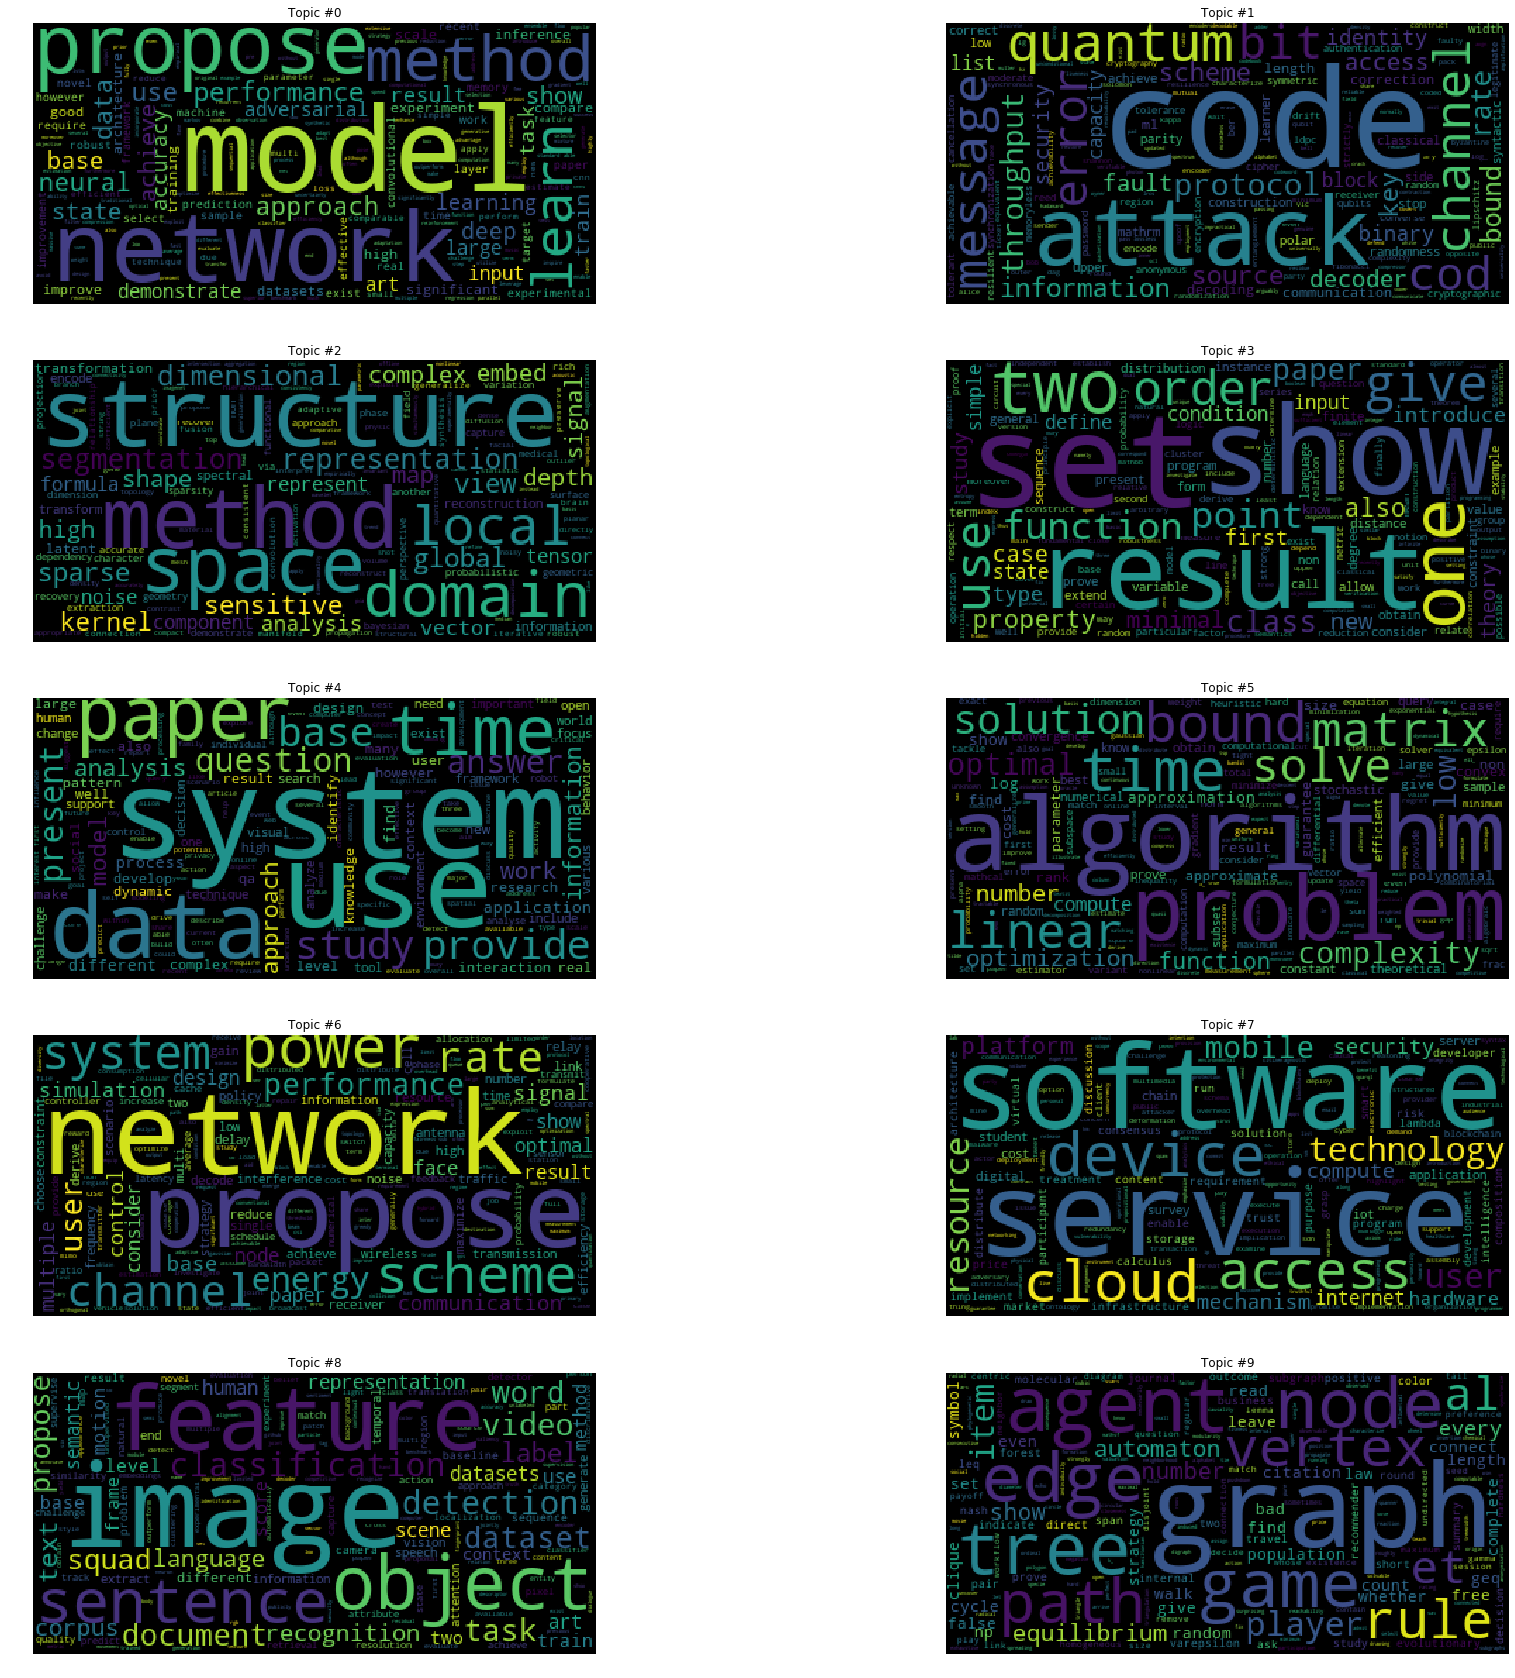

In [11]:
topic_model.vizualize_result()

In [17]:
similar_doc_ind = None

idx = 60000
doc  = df.iloc[idx]["abstract"]
topic_model.add_doc(doc, idx=idx)

%time recommended_ids = topic_model.recommend_from_id_(idx, num_similar_docs=10)
similar_doc_idx = recommended_ids[1]
for ridx in recommended_ids:
    print("[recommend ]" + str(ridx))

Add new document on corpus and topic distoribution indecies.
CPU times: user 854 ms, sys: 6.68 ms, total: 860 ms
Wall time: 863 ms
[recommend ]60000
[recommend ]4785
[recommend ]26492
[recommend ]3786
[recommend ]36889
[recommend ]12139
[recommend ]691
[recommend ]23510
[recommend ]2812
[recommend ]40895


Text(0.5, 1.0, 'Document ID: 4785')

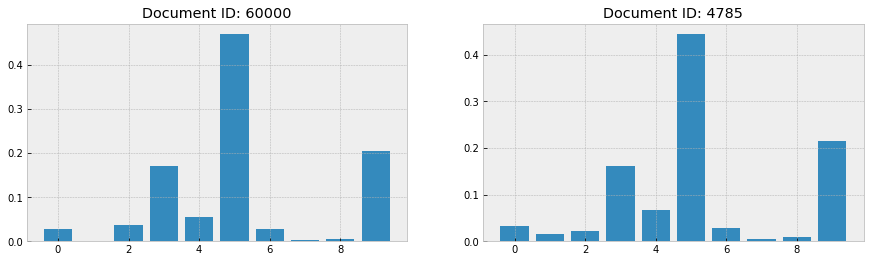

In [18]:
doc  = df.iloc[idx]["abstract"]
corpus = topic_model.corpus_from_doc(doc)
topic_distoribution = topic_model.lda.get_document_topics(corpus)

fig = plt.figure(figsize=(15, 4 ))
plt.style.use('bmh')

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar([e[0] for e in topic_distoribution], [e[1] for e in topic_distoribution])
ax1.set_title("Document ID: " + str(idx))

ax2 = fig.add_subplot(1, 2, 2)
doc  = df.iloc[similar_doc_idx]["abstract"]
corpus = topic_model.corpus_from_doc(doc)
topic_distoribution = topic_model.lda.get_document_topics(corpus)
ax2.bar([e[0] for e in topic_distoribution], [e[1] for e in topic_distoribution])
ax2.set_title("Document ID: " +  str(similar_doc_idx))

In [19]:
# Target
# ind = 18000 
target_doc_title  = df.iloc[idx]["title"]
target_doc  = df.iloc[idx]["abstract"]
topic_model.add_doc(doc, idx=idx)

print("* Target document: ")
print(target_doc_title.upper())
print(target_doc)
print("----")

# Similar 
print("* Similar document: ")
count = 0
for similar_doc_idx in recommended_ids:
    if count == 0:
        count += 1
        continue
        
    if count > 5:
        break
        
    similar_doc_title = df.iloc[similar_doc_idx]["title"]
    similar_doc  = df.iloc[similar_doc_idx]["abstract"]
    print(similar_doc_title.upper())
    print(similar_doc)
    print("----")
    
    count += 1

[Error] There is the same ID in corpus.
* Target document: 
STRUCTURALLY PARAMETERIZED D-SCATTERED SET
in $d$-scattered set we are given an (edge-weighted) graph and are asked to select at least $k$ vertices, so that the distance between any pair is at least $d$, thus generalizing independent set. we provide upper and lower bounds on the complexity of this problem with respect to various standard graph parameters. in particular, we show the following:   - for any $d\ge2$, an $o^*(d^{\textrm{tw}})$-time algorithm, where $\textrm{tw}$ is the treewidth of the input graph.   - a tight seth-based lower bound matching this algorithm's performance. these generalize known results for independent set.   - $d$-scattered set is w[1]-hard parameterized by vertex cover (for edge-weighted graphs), or feedback vertex set (for unweighted graphs), even if $k$ is an additional parameter.   - a single-exponential algorithm parameterized by vertex cover for unweighted graphs, complementing the above-menti